<a href="https://colab.research.google.com/github/Oleksij-gh/infotech-task/blob/main/infotech_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do:

исправить баг с y_val_

Идеи:
1. Обучить две разные модели

* На время взлёта
* На врема посадки

2. Обучить модель на общее время задержки рейса

# 1. Libs

In [1]:
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# 2. Loading Data

In [2]:
!gdown 1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi

Downloading...
From: https://drive.google.com/uc?id=1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi
To: /content/schedule_dataset.xlsx
100% 8.31M/8.31M [00:00<00:00, 131MB/s]


In [3]:
df = pd.read_excel('/content/schedule_dataset.xlsx')

In [4]:
df.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


# 3. Data preprocessing

In [5]:
df.columns

Index(['Дата рейса', 'Рейс', 'А/П отправл', 'А/П прибыт', 'Номер ВС',
       'Время отправления по расписанию', 'Время отправления фактическое',
       'Время прибытия по расписанию', 'Время прибытия фактическое'],
      dtype='object')

Переименуем столбцы

In [6]:
df  = df.rename(columns={'Дата рейса': 'flight_date',
                   'Рейс': 'flight',
                   'А/П отправл': 'airport_out',
                   'А/П прибыт': 'airport_in',
                   'Номер ВС': 'air_number',
                   'Время отправления по расписанию': 'scheduled_time_out',
                   'Время отправления фактическое': 'actual_time_out',
                   'Время прибытия по расписанию': 'scheduled_time_in',
                   'Время прибытия фактическое': 'actual_time_in'})

In [7]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


Проверка на пустые строки

In [8]:
df.isna().values.any()

False

Рассчитаем задержку взлёта и посадки, а также ожидаемое и фактическое время полёта

In [9]:
df['scheduled_time_sec'] = df.apply(lambda x: (x['scheduled_time_in'] - x['scheduled_time_out']).total_seconds(), axis=1)
#df['scheduled_time_sec'] = df.apply(lambda x: x['scheduled_time'].total_seconds(), axis=1)
df['actual_time_sec'] = df.apply(lambda x: (x['actual_time_in'] - x['actual_time_out']).total_seconds(), axis=1)
#df['actual_time_sec'] = df.apply(lambda x: x['actual_time'].total_seconds(), axis=1)
df['delay_out_sec'] = df.apply(lambda x: (x['actual_time_out'] - x['scheduled_time_out']).total_seconds(), axis=1)
df['delay_in_sec'] = df.apply(lambda x: (x['actual_time_in'] - x['scheduled_time_in'] ).total_seconds() , axis=1)




Извлечем день и месяц полёта в отдельные признаки

In [10]:
df['flight_month'] = df.apply(lambda x: x['flight_date'].month, axis=1)
df['flight_day'] = df.apply(lambda x: x['flight_date'].day, axis=1)
df['day_of_the_week'] = df.apply(lambda x: x['flight_date'].day_name(), axis=1)

Извлечем время взлёта\посадки в отдельный категориальный признак

In [11]:
df['time_part_out'] = df.apply(lambda x: (x['scheduled_time_out'].hour) // 3, axis=1)
df['time_part_in'] = df.apply(lambda x: (x['scheduled_time_in'].hour) // 3, axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139732 entries, 0 to 139731
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   flight_date         139732 non-null  datetime64[ns]
 1   flight              139732 non-null  int64         
 2   airport_out         139732 non-null  object        
 3   airport_in          139732 non-null  object        
 4   air_number          139732 non-null  int64         
 5   scheduled_time_out  139732 non-null  datetime64[ns]
 6   actual_time_out     139732 non-null  datetime64[ns]
 7   scheduled_time_in   139732 non-null  datetime64[ns]
 8   actual_time_in      139732 non-null  datetime64[ns]
 9   scheduled_time_sec  139732 non-null  float64       
 10  actual_time_sec     139732 non-null  float64       
 11  delay_out_sec       139732 non-null  float64       
 12  delay_in_sec        139732 non-null  float64       
 13  flight_month        139732 no

Преобразование номера ВС к типу object, т.к. это категориальный признак и в дальнейшем будет преобразован с помощью endcoder

In [13]:
df['air_number'] = df['air_number'].astype(object)
df['time_part_out'] = df['time_part_out'].astype(object)
df['time_part_in'] = df['time_part_in'].astype(object)

In [14]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in,scheduled_time_sec,actual_time_sec,delay_out_sec,delay_in_sec,flight_month,flight_day,day_of_the_week,time_part_out,time_part_in
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00,6900.0,7200.0,-1020.0,-720.0,3,1,Thursday,0,0
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,5100.0,6900.0,-300.0,1500.0,3,1,Thursday,0,0
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00,8700.0,8280.0,-60.0,-480.0,3,1,Thursday,0,0
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,4500.0,5280.0,-540.0,240.0,3,1,Thursday,0,0
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,8100.0,8400.0,-240.0,60.0,3,1,Thursday,0,0


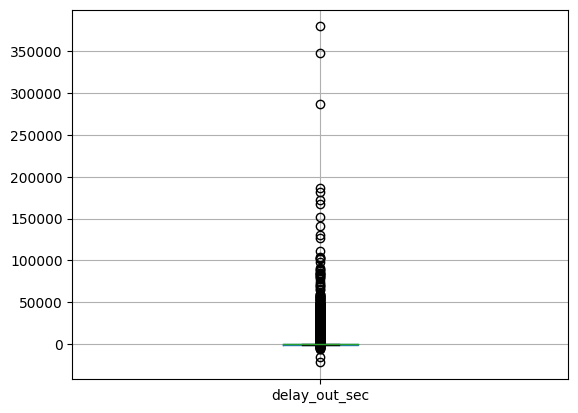

In [15]:
boxplot = df.boxplot(column=['delay_out_sec'])

In [16]:
Q1 =  df['delay_out_sec'].quantile(0.25)
Q3 = df['delay_out_sec'].quantile(0.75)
IQR = Q3 - Q1
df_out = df[(df['delay_out_sec'] > (Q1-1.5*IQR)) & (df['delay_out_sec'] < (Q3+1.5*IQR))]

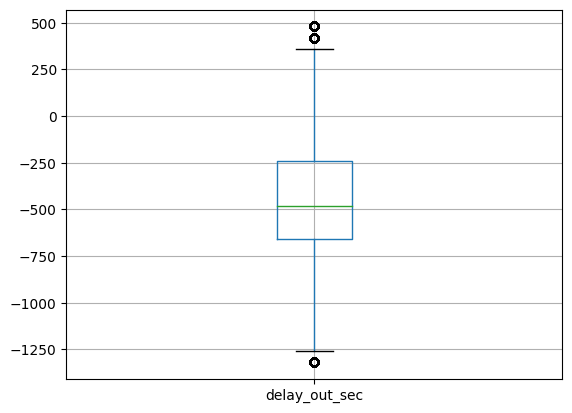

In [17]:
boxplot = df_out.boxplot(column=['delay_out_sec'])

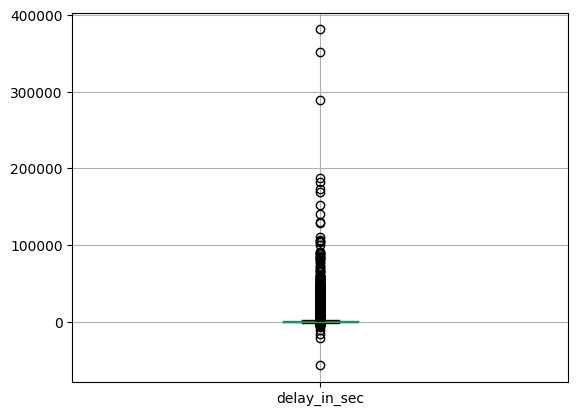

In [18]:
boxplot = df.boxplot(column=['delay_in_sec'])

In [19]:
Q1 =  df['delay_in_sec'].quantile(0.25)
Q3 = df['delay_in_sec'].quantile(0.75)
IQR = Q3 - Q1
df_in = df[(df['delay_in_sec'] > (Q1-1.5*IQR)) & (df['delay_in_sec'] < (Q3+1.5*IQR))]

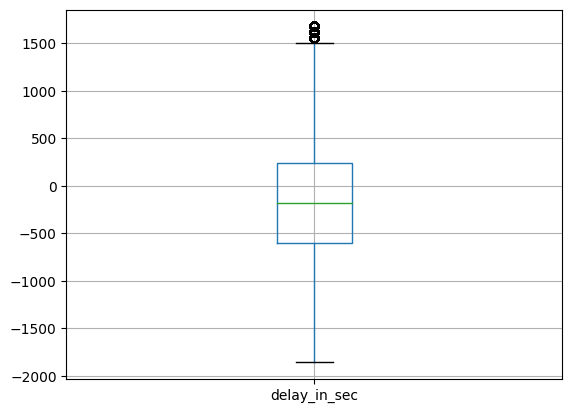

In [20]:
boxplot = df_in.boxplot(column=['delay_in_sec'])

# Формирование датасета

In [21]:
!pip install category_encoders --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


Кодируем категориальные признаки, выбран CatBoost Encoder, основываясь на сравнении в [бенчмарках](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark)

In [22]:
from category_encoders.cat_boost import CatBoostEncoder

In [23]:
CBencoder = CatBoostEncoder()
cbe_out = CBencoder.fit_transform(df_out[['airport_out', 'airport_in', 'air_number', 'day_of_the_week', 'time_part_out']], df_out['delay_out_sec'])
cbe_in = CBencoder.fit_transform(df_in[['airport_out', 'airport_in', 'air_number', 'day_of_the_week', 'time_part_in']], df_in['delay_in_sec'])

In [24]:
data_out = pd.concat([cbe_out, df_out[['flight_month', 'flight_day', 'flight']]], axis=1)
data_in = pd.concat([cbe_in, df_in[['flight_month', 'flight_day', 'flight']]], axis=1)

Для delay_out_sec

In [25]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(data_out, df_out['delay_out_sec'], test_size=0.2, random_state=1)

X_train_out, X_val_out, y_train_out, y_val_out = train_test_split(X_train_out, y_train_out, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

Для delay_in_sec

In [26]:
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(data_in, df_in['delay_in_sec'], test_size=0.2, random_state=1)

X_train_in, X_val_in, y_train_in, y_val_in = train_test_split(X_train_in, y_train_in, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# 4. Models

## 4.1 CatBoost regressor

In [27]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [28]:
from catboost import CatBoostRegressor
CBRmodel = CatBoostRegressor(
                          verbose=5000,
                          task_type='GPU',
                          loss_function='RMSE',
                          iterations = 20000,
                          depth = 12,
                          random_state=42,
                          l2_leaf_reg=1,
                          learning_rate=0.03
 )

CBRmodel.fit(X_train_out, y_train_out)
#params = {'l2_leaf_reg':[1,4,8],
#          'learning_rate': [0.03,0.5,0.1],
#          'depth':[6,8,10]
#         }
#grid_search_res = CBRmodel.grid_search(params, X_train_out, y_train_out, train_size=0.8)

0:	learn: 329.3896762	total: 127ms	remaining: 42m 12s
5000:	learn: 152.1740832	total: 1m 46s	remaining: 5m 20s
10000:	learn: 98.1105201	total: 3m 26s	remaining: 3m 26s
15000:	learn: 67.4654094	total: 4m 55s	remaining: 1m 38s
19999:	learn: 48.2017708	total: 6m 26s	remaining: 0us


In [29]:
error = -cross_val_score(
                      CBRmodel,
                      X_val_out,
                      y_val_out,
                      cv=2,
                      scoring="neg_mean_squared_error").mean()
# print(R2CV)
print(np.sqrt(error))

0:	learn: 331.5026784	total: 318ms	remaining: 1h 46m 8s
5000:	learn: 252.8099692	total: 3m 49s	remaining: 11m 28s
10000:	learn: 245.1637587	total: 5m 40s	remaining: 5m 40s
15000:	learn: 240.9936435	total: 7m 23s	remaining: 2m 27s
19999:	learn: 236.9379181	total: 9m 5s	remaining: 0us
0:	learn: 332.4795434	total: 181ms	remaining: 1h 19s
5000:	learn: 253.0413530	total: 3m 51s	remaining: 11m 33s
10000:	learn: 244.0482044	total: 6m 16s	remaining: 6m 16s
15000:	learn: 237.7269460	total: 8m 44s	remaining: 2m 54s
19999:	learn: 233.2379168	total: 11m 20s	remaining: 0us
307.74635094248174


In [30]:
# Predict the model
pred = CBRmodel.predict(X_val_out)

# RMSE, MAE Computation
rmse = np.sqrt(MSE(pred, y_val_out))
mae = MAE(pred, y_val_out)
print(f'RMSE: {rmse}, MAE: {mae}')

RMSE: 322.1024404592049, MAE: 251.8020708027445


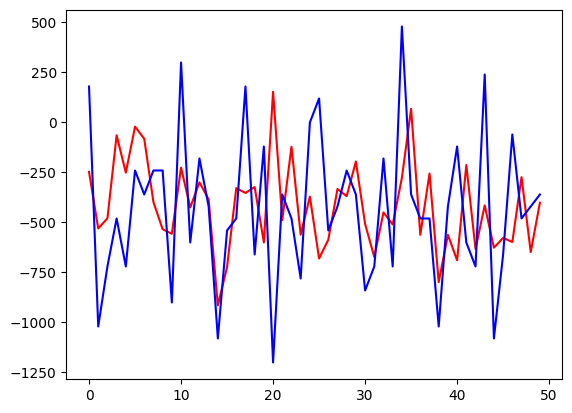

In [36]:
i = 8
t = np.arange(0., 50., 1)
plt.plot(t, pred[50 * i:50 * (i + 1)], color='red')
plt.plot(t, y_val_out[50 * i:50 * (i + 1)], color='blue')
plt.show()

## 4.2 XGBoost

In [46]:
import xgboost as xg

In [47]:
xgb_r = xg.XGBRegressor(n_estimators = 500, seed = 42)

# Fitting the model
xgb_r.fit(X_train_out, y_train_out)

# Predict the model
pred = xgb_r.predict(X_val_out)

# RMSE, MAE Computation
rmse = np.sqrt(MSE(pred, y_val_out))
mae = MAE(pred, y_val_out)
print(f'RMSE: {rmse}, MAE: {mae}')

RMSE: 303.27985640199694, MAE: 236.0430454931629


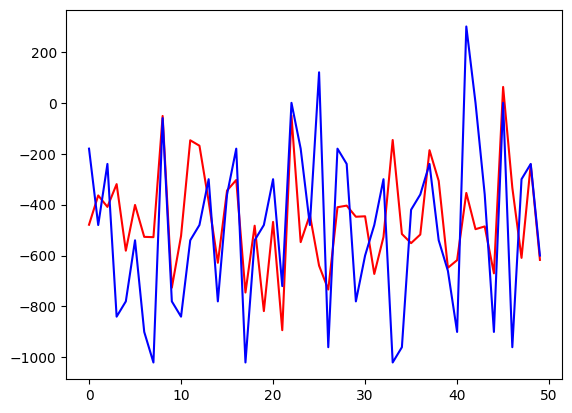

In [48]:
t = np.arange(0., 50., 1)
plt.plot(t, pred[:50], color='red')
plt.plot(t, y_val_out[:50], color='blue')
plt.show()

## 4.3 PyTorch

In [49]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Out

In [50]:
X_train = torch.tensor(X_train_out.values, dtype=torch.float32)
y_train = torch.tensor(y_train_out.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_out.values, dtype=torch.float32)
y_test = torch.tensor(y_test_out.values, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val_out.values, dtype=torch.float32)
y_val = torch.tensor(y_val_out.values, dtype=torch.float32).reshape(-1, 1)

### In

In [121]:
X_train = torch.tensor(X_train_in.values, dtype=torch.float32)
y_train = torch.tensor(y_train_in.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_in.values, dtype=torch.float32)
y_test = torch.tensor(y_test_in.values, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val_in.values, dtype=torch.float32)
y_val = torch.tensor(y_val_in.values, dtype=torch.float32).reshape(-1, 1)

### NN

In [122]:
import torch.nn as nn
import torch.nn.functional as F


class RegModel(nn.Module):

    def __init__(self):
        super(RegModel, self).__init__()

        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.dropout(x))
        x = F.relu(self.fc5(x))

        return self.fc6(x)


In [125]:
learning_rate = 1e-3

model = RegModel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
#critrion = nn.NLLLoss()

# training parameters
n_epochs = 2   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_rmse = np.inf   # init to infinity
best_weights = None
history = []


In [126]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            #loss = torch.sqrt(criterion(y_pred, y_batch))
            loss = criterion(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(rmse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    #rmse = torch.sqrt(criterion(y_pred, y_test))
    rmse = criterion(y_pred, y_test)
    rmse = float(rmse)
    history.append(rmse)
    if rmse < best_rmse:
        best_mse = rmse
        best_weights = copy.deepcopy(model.state_dict())

Epoch 1: 100%|██████████| 2458/2458 [00:23<00:00, 104.70batch/s, rmse=433]


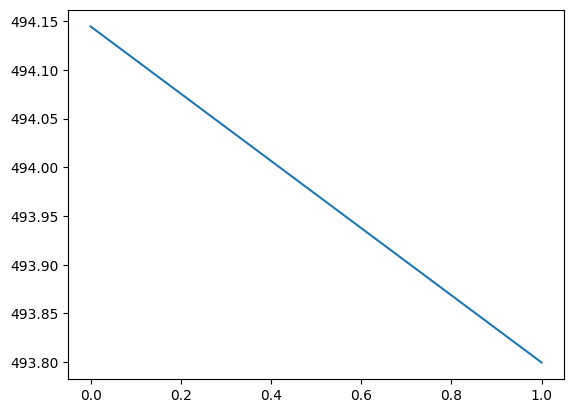

In [127]:
plt.plot(history)
plt.show()

In [129]:
# Predict the model
pred = model(X_val)
pred = pred.detach().numpy()
# RMSE, MAE Computation
rmse = np.sqrt(MSE(pred, y_val_in))
mae = MAE(pred, y_val_in)
print(f'RMSE: {rmse}, MAE: {mae}')

RMSE: 635.847185691736, MAE: 498.03850822484736


In [93]:
pred[:10]

array([[-545.81165],
       [-477.7596 ],
       [-582.84485],
       [-471.63745],
       [-539.1696 ],
       [-456.46582],
       [-483.2956 ],
       [-558.457  ],
       [-246.85762],
       [-526.47876]], dtype=float32)

In [94]:
y_val_out[:10]

113571    -180.0
20711     -480.0
47436     -240.0
39595     -840.0
47984     -780.0
126468    -540.0
61614     -900.0
27601    -1020.0
76306      -60.0
50916     -780.0
Name: delay_out_sec, dtype: float64

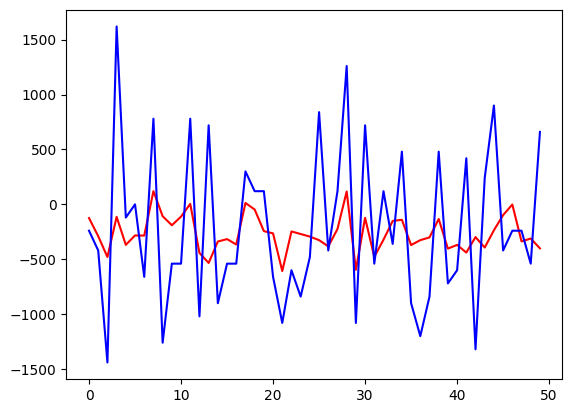

In [130]:
t = np.arange(0., 50., 1)
plt.plot(t, pred[50:100], color='red')
plt.plot(t, y_val_in[50:100], color='blue')
plt.show()

# Chronos Time-series AMAZON

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git --quiet

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

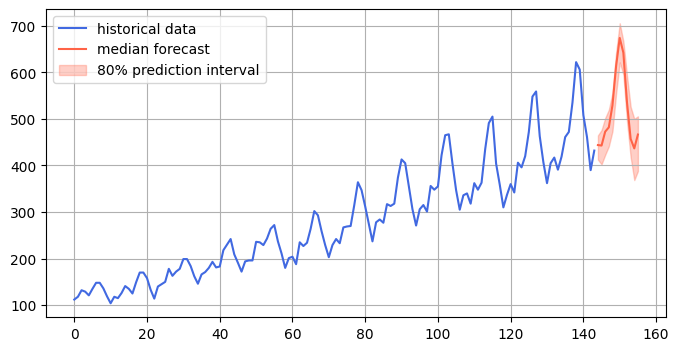

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  #device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [4]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
